In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from scipy.stats import pearsonr, gaussian_kde
from sklearn.metrics import root_mean_squared_error

# plt.rc('font',family='Times New Roman') #设置全局字体
# plt.rc('font',family='Arial') #设置全局字体
# 设置图片清晰度
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.family'] = "Arial"


D:\Soft\code_soft\anaconda\envs\rgis9\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### 绘制散点图0：

In [16]:
def calculate_metrics(y_true, y_pred):
    """
    计算预测值和真实值之间的相关系数（R）、平均偏差误差（MBE）、
    百分比平均偏差误差（%MBE）、均方根误差（RMSE）和百分比均方根误差（%RMSE）。

    参数:
    y_true: np.array, 真实值
    y_pred: np.array, 预测值

    返回:
    dict: 包含R, MBE, %MBE, RMSE, %RMSE的字典
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 相关系数 R
    R, _ = pearsonr(y_true, y_pred)
    # 计算误差
    error = y_pred - y_true
    # 平均偏差误差（MBE）
    MBE = np.mean(error)
    # 百分比平均偏差误差（%MBE）
    MBE_percent = (MBE / np.mean(y_true)) * 100
    # 均方根误差（RMSE）
    RMSE = root_mean_squared_error(y_true, y_pred)
    # 百分比均方根误差（%RMSE）
    RMSE_percent = (RMSE / np.sqrt(np.mean(y_true**2))) * 100

    return {
        "R": R,
        "MBE": MBE,
        "%MBE": MBE_percent,
        "RMSE": RMSE,
        "%RMSE": RMSE_percent
    }

# 示例使用
y_true = [3, 5, 2.5, 7, 4.5]
y_pred = [6, 10, 5, 14, 9]
# 转为df
df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})

metrics = calculate_metrics(y_true, y_pred)
print(metrics['R'])
def calculate_error(observation, model):
    valid_mask = ~np.isnan(observation) & ~np.isnan(model)
    valid_obs = observation[valid_mask]
    valid_mod = model[valid_mask]

    metrics = calculate_metrics(valid_obs, valid_mod)

    return metrics
calculate_error(df['y_true'], df['y_pred'])

0.9999999999999997


{'R': 0.9999999999999997,
 'MBE': 4.4,
 '%MBE': 100.0,
 'RMSE': 4.679743582719036,
 '%RMSE': 100.0}

In [46]:
# 读取数据库
database = pd.read_feather(r'D:\PhD\data\station_feather\station_data_all_v3.feather').rename(columns={'daily_radiation':'Observation'})
models_name = ['ISCCP-ITP', 'GLASS', 'ERA5', 'MERRA2', 'SSP245', 'SSP585']
# 计算评价指标
metrics_list = []
for model in models_name:
    metrics = calculate_error(database['Observation'], database[model])
    metrics_list.append(metrics)


# 读取数据
sample_num = 100000
database_ISCCP  = database[~database['ISCCP-ITP'].isna()][['Observation','ISCCP-ITP']].rename(columns={'ISCCP-ITP':'Model'}).sample(sample_num).reset_index(drop=True)
database_GLASS  = database[~database['GLASS'].isna()][['Observation','GLASS']].rename(columns={'GLASS':'Model'}).sample(sample_num).reset_index(drop=True)
database_ERA5   = database[~database['ERA5'].isna()][['Observation','ERA5']].rename(columns={'ERA5':'Model'}).sample(sample_num).reset_index(drop=True)
database_MERRA2 = database[['Observation','MERRA2']].rename(columns={'MERRA2':'Model'}).sample(sample_num).reset_index(drop=True)
database_SSP245 = database[~database['SSP245'].isna()][['Observation','SSP245']].rename(columns={'SSP245':'Model'}).sample(sample_num).reset_index(drop=True)
database_SSP585 = database[~database['SSP585'].isna()][['Observation','SSP585']].rename(columns={'SSP585':'Model'}).sample(sample_num).reset_index(drop=True)

del database

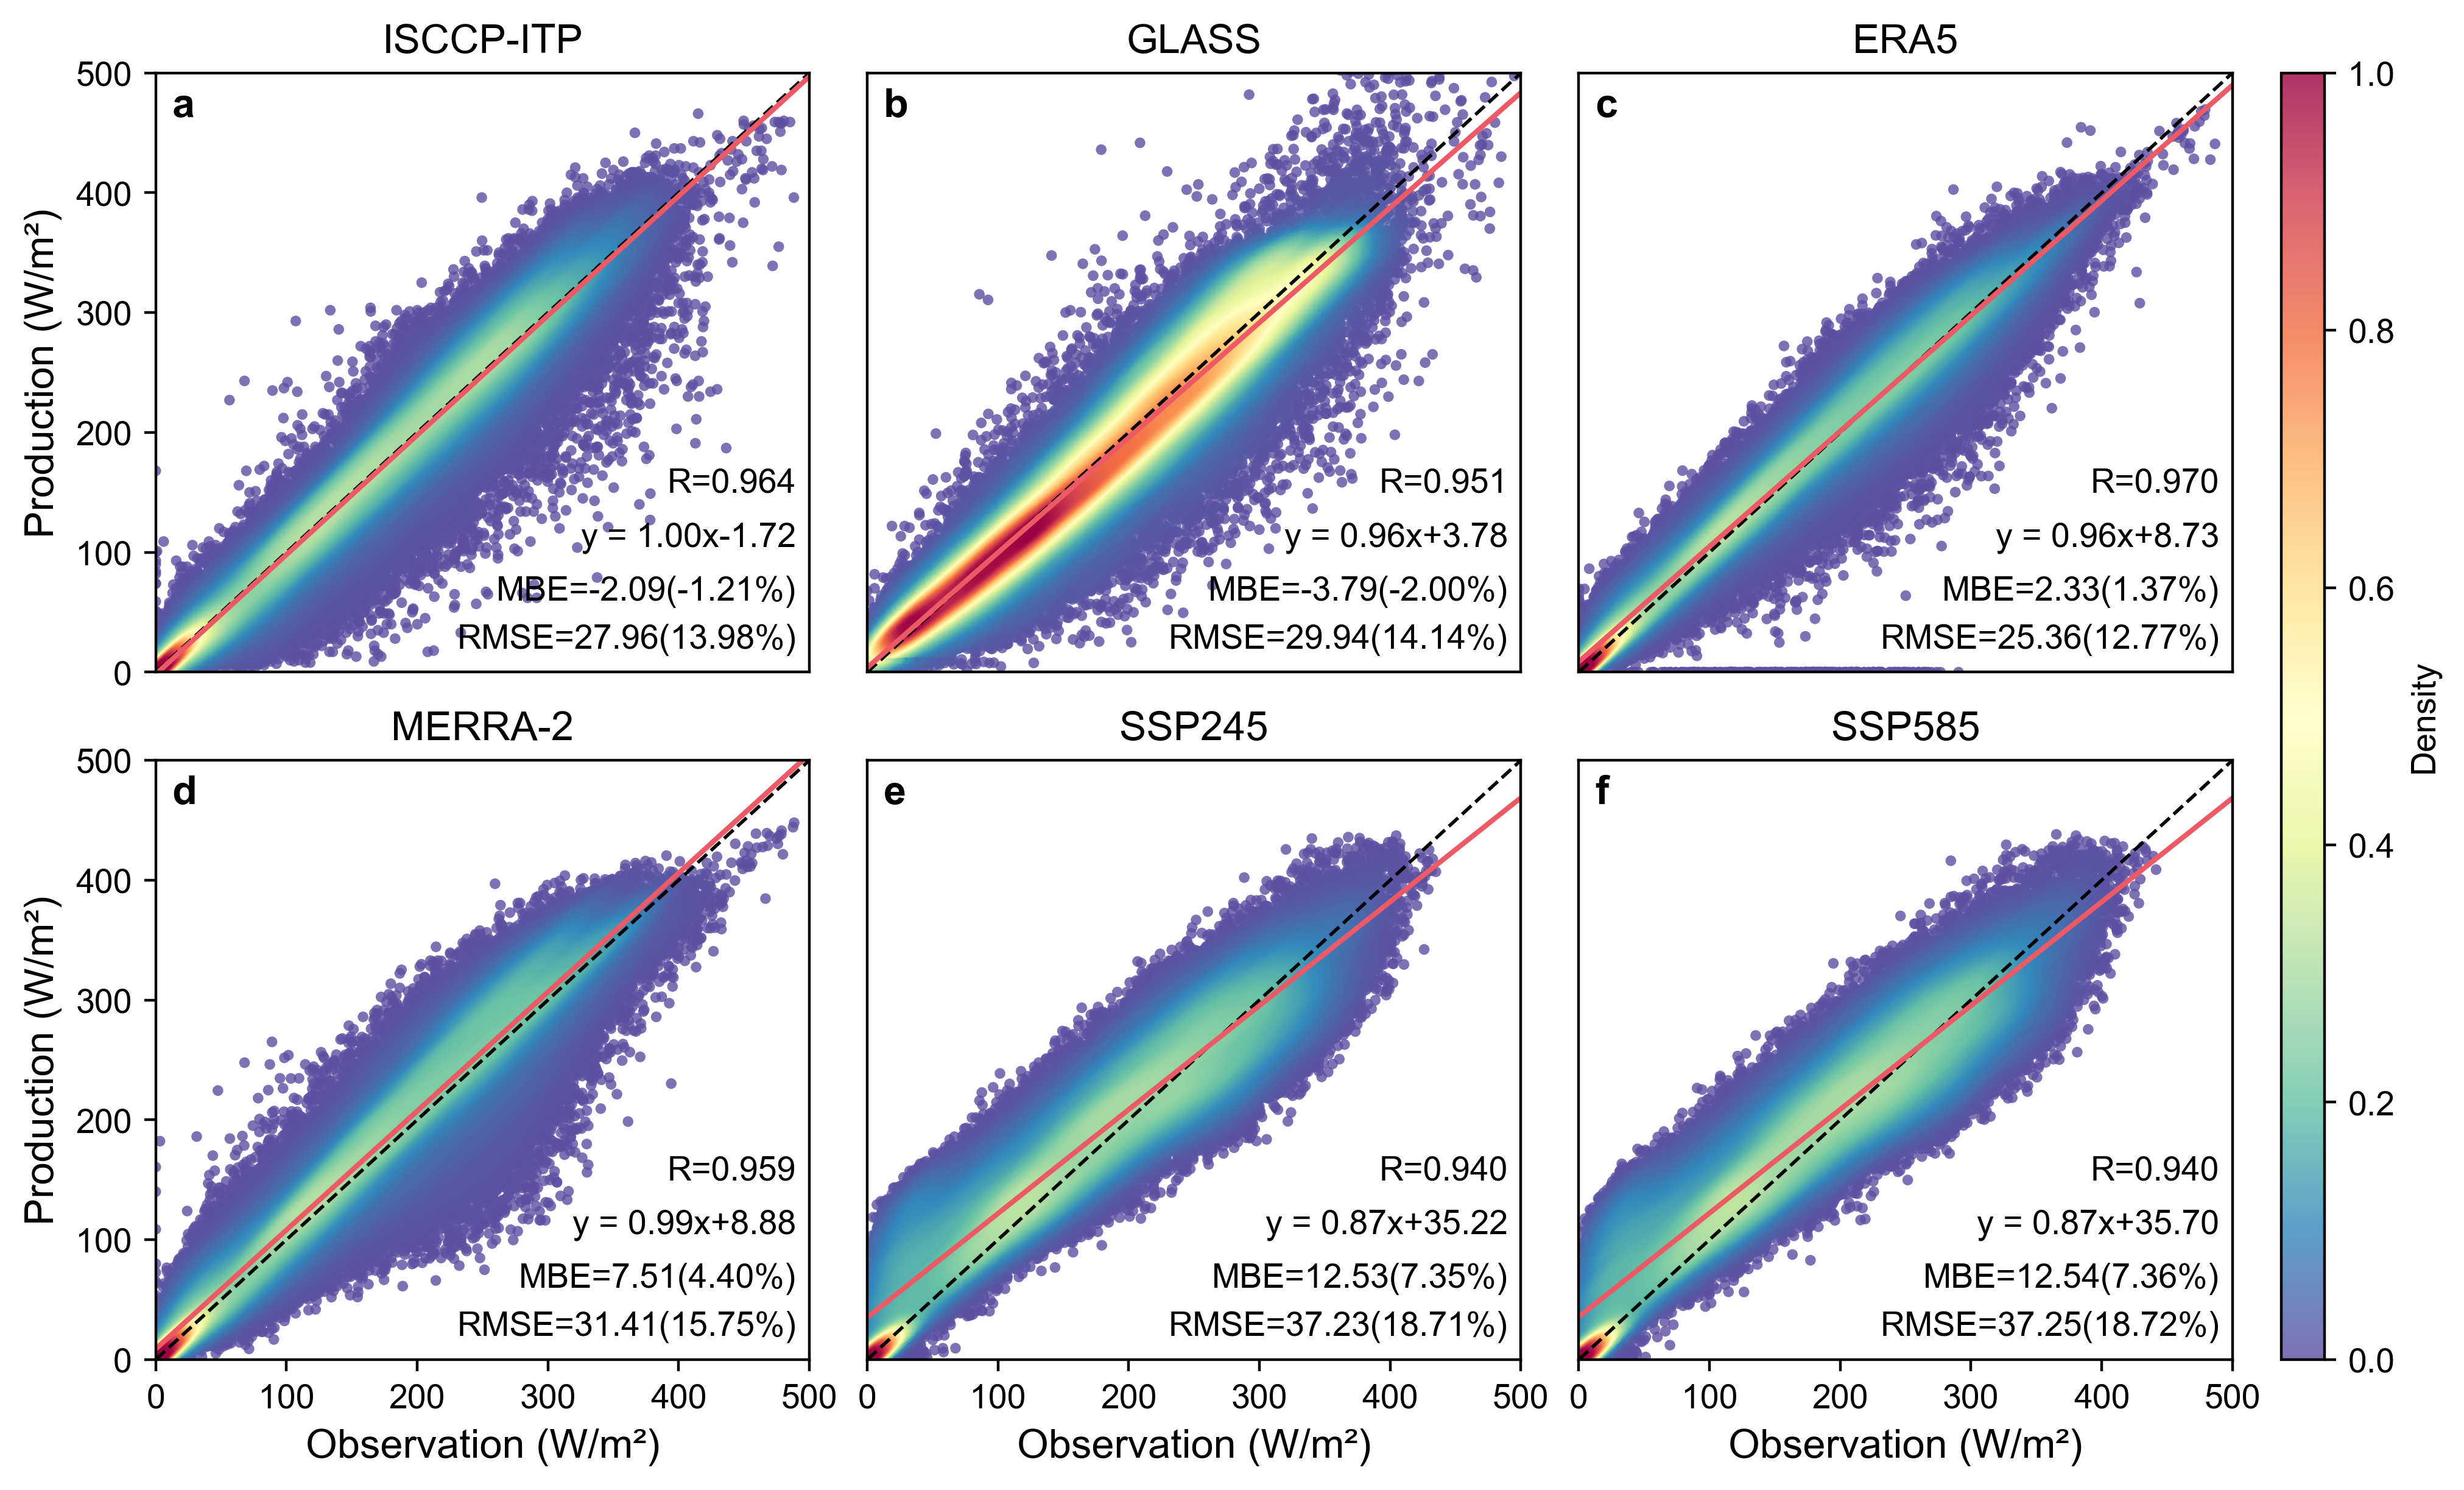

In [47]:
# 绘图

models = [database_ISCCP, database_GLASS, database_ERA5, database_MERRA2, database_SSP245, database_SSP585]
models_name = ['ISCCP-ITP', 'GLASS', 'ERA5', 'MERRA-2', 'SSP245', 'SSP585']
axs_num = ['a', 'b', 'c', 'd', 'e', 'f']
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(10, 6))
i = 1
scatter = None  # 初始化scatter变量以便后续使用
for model, ax, model_name, metrics, ax_num in zip(models, axs.flatten(), models_name, metrics_list, axs_num):
    # 标题
    ax.set_title(model_name, fontsize=12)
    # 绘制密度散点图
    density = gaussian_kde(np.vstack([model['Observation'], model['Model']]))(np.vstack([model['Observation'], model['Model']]))
    idx = density.argsort()
    scatter = ax.scatter(model['Observation'][idx], model['Model'][idx], c=density[idx], alpha=0.8, cmap="Spectral_r", edgecolors='none', s=10)


    # 对角线
    ax.plot([0, 500], [0, 500], "k--", lw=1)
    # 拟合线
    slope, intercept = np.polyfit(model['Observation'], model['Model'], 1)
    x_fit = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    y_fit = slope * x_fit + intercept
    ax.plot(x_fit, y_fit, color='#ed5a65', label='Regression Line')
    # 轴显示范围
    ax.set_xlim(0, 500)
    # ax.set_xticks(range(0, 501, 20))
    ax.set_ylim(0, 500)
    # ax.set_yticks(0, 501, 20)
    # 轴标签
    if i > 3:
        ax.set_xlabel('Observation (W/m²)', fontsize=12)
    if i == 1 or i == 4:
        ax.set_ylabel('Production (W/m²)', fontsize=12)
    if i < 4:
        ax.axes.xaxis.set_visible(False)
    if i in [2, 3, 5, 6]:
        ax.axes.yaxis.set_visible(False)

    # 计算指标
    # metrics = calculate_metrics(model['Observation'], model['Model'])
    sign = "+" if intercept >= 0 else "-"
    formula_text = f'y = {slope:.2f}x{sign}{abs(intercept):.2f}'
    # 可视化指标文本
    ax.text(0.025, 0.975, ax_num,transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.text(0.98, 0.30, f'R={metrics["R"]:.3f}', transform=ax.transAxes, fontsize=10, horizontalalignment='right')
    ax.text(0.98, 0.21, formula_text, transform=ax.transAxes, fontsize=10, horizontalalignment='right')
    ax.text(0.98, 0.12, f'MBE={metrics["MBE"]:.2f}({metrics["%MBE"]:.2f}%)', transform=ax.transAxes, fontsize=10, horizontalalignment='right')
    ax.text(0.98, 0.04, f'RMSE={metrics["RMSE"]:.2f}({metrics["%RMSE"]:.2f}%)', transform=ax.transAxes, fontsize=10, horizontalalignment='right')
    i += 1


fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1), cmap="Spectral_r"), ax=axs, pad=0.01, orientation='vertical', aspect=30, alpha=0.8, label='Density')
# 保存png
# plt.savefig(r'D:\PhD\UCAS\Undergraduate\Projects\Python\output10000.png', dpi=1000, bbox_inches='tight')